In [33]:
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from sklearn import preprocessing, model_selection
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import metrics


In [2]:
df = pd.read_csv("data/weatherAUS.csv")
display(df.head())
df.info()
print(f"null count: {df.isnull().sum().sum()}")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [3]:
df.dropna(axis=1, thresh=round(df.shape[0]*0.6), inplace=True)
df.shape

(145460, 20)

In [4]:
def rain_transofrm(sample): # Оставим пропуски
    if sample =='Yes':
        return 1
    if sample =='No':
        return 0 
    return sample
df['RainToday'] =  df['RainToday'].apply(rain_transofrm)
df['RainTomorrow'] =  df['RainTomorrow'].apply(rain_transofrm)
# df.RainToday = df.RainToday.map({'No': 0, 'Yes': 1})
# df.RainTomorrow = df.RainTomorrow.map({'No': 0, 'Yes': 1})

In [5]:
df['Month'] = pd.to_datetime(df['Date'], yearfirst=True).dt.month
df.drop('Date', axis=1, inplace=True)
# Most rainy months by part of rainy days
(df.groupby("Month")['RainToday'].mean()).sort_values(ascending=False)*100

Month
7     27.073606
6     26.363783
8     25.316671
9     22.913545
5     22.216266
3     21.713453
4     21.684509
12    21.303745
11    21.084337
2     20.674584
10    19.651173
1     18.948428
Name: RainToday, dtype: float64

In [6]:
categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_ = pd.get_dummies(df, columns=categoricals)
df_.shape

(145460, 124)

In [16]:
df_.dropna(axis=0, how='any', inplace=True)
X = df_.drop('RainTomorrow', axis=1)
y = df_['RainTomorrow']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,test_size=0.3,
                                                                    random_state=31)

In [8]:
X_train_ = X_train['MinTemp'].reset_index(drop=True)
X_train_.sample()
np.random.seed(31)
min_temp_mean = list()
for i in range(1000):
    indexes = np.random.randint(0, X_train_.shape[0], size=X_train_.shape[0])
    bs = X_train_[indexes]
    min_temp_mean.append(bs.mean())
np.std(min_temp_mean) # оценка стандартного отклонения средних

0.02879072820657669

In [9]:
def gbs(data, n):     
    inds = np.random.randint(0, len(data), (n, len(data))) #определяем индексы случайным образом
    numbers = data[inds] #выбираем значения по индексам
    return numbers
target = X_train['MinTemp'].values #выбираем целевую переменную
np.random.seed(31) #задаём параметр генератора случайных чисел
mean_values = [np.mean(x) for x in gbs(target, 1000)] #получаем все средние значения
print(np.std(mean_values)) #находим для них стандартное отклонение

0.02879072820657669


In [17]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.transform(X_test)

In [21]:
baseline = LogisticRegression(solver='lbfgs', max_iter=100)
baseline.fit(X_train,y_train)
metrics.roc_auc_score(y_test, baseline.predict(X_test))

c:\Users\mblyz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7261883053393459

In [46]:
param_grid = {'min_samples_split': [2, 3, 4,5,6,7], 'max_depth': [5,7,9,11], 'min_samples_leaf':list(range(2,10))}
gsv = model_selection.GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3
)
gsv.fit(X_train,y_train)
print(gsv.best_params_)
metrics.roc_auc_score(y_test, gsv.best_estimator_.predict(X_test))

0.5706970790178053

In [31]:
gsv.best_estimator_.get_n_leaves()

121

In [56]:
rf = RandomForestClassifier(100, random_state=31)
rf.fit(X_train, y_train)
metrics.roc_auc_score(y_test, rf.predict(X_test))

0.7329684570290497

In [50]:
display(y_test)
metrics.f1_score(y_test, np.round(rf.predict(X_test)))

36523     0.0
86735     1.0
94991     1.0
23569     1.0
106935    0.0
         ... 
47749     0.0
70054     1.0
108459    0.0
139602    0.0
105281    0.0
Name: RainTomorrow, Length: 23478, dtype: float64

0.6279349131811729

In [68]:
# param_grid = {'min_samples_leaf': [3, 5, 7, 9, 11], 'max_depth': [7, 11, 15]}
param_grid = {'max_features': [ 4, 5, 6, 7], 'min_samples_leaf': [3, 5, 7, 9, 11], 'max_depth': [5, 10, 15]}
gsv = model_selection.GridSearchCV(
    RandomForestClassifier(random_state=31),
    param_grid=param_grid,
    cv=3,
    verbose=2
)
gsv.fit(X_train,y_train)
print(gsv.best_params_)
metrics.roc_auc_score(y_test,  np.round(gsv.best_estimator_.predict(X_test)))


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=3; total time=   1.0s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=3; total time=   1.4s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=3; total time=   1.0s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=5; total time=   1.1s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=5; total time=   1.0s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=5; total time=   1.0s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=7; total time=   1.0s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=7; total time=   1.4s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=7; total time=   0.9s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=9; total time=   0.8s
[CV] END ....max_depth=5, max_features=4, min_samples_leaf=9; total time=   0.9s
[CV] END ....max_depth=5, max_features=4, min_s

0.7005484843285417

In [69]:
metrics.f1_score(y_test, gsv.best_estimator_.predict(X_test))

0.561323032351521

In [ ]:
rf.feature_importances_

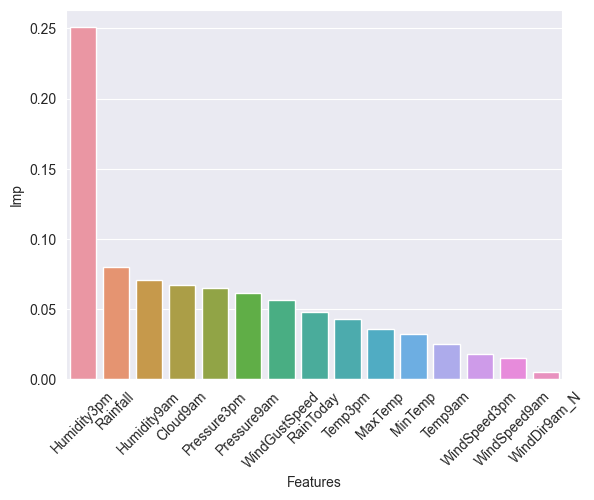

In [70]:
best = gsv.best_estimator_
feature_imp = pd.DataFrame({'Features':X_train.columns, 'Imp': best.feature_importances_})
sns.barplot(feature_imp.sort_values(by='Imp', ascending=False)[:15], x='Features', y='Imp').xaxis.set_tick_params(rotation=45);